#### Import libaries

In [6]:
%pip install scipy
%pip install matplotlib
%pip install ipywidgets
%pip install ipympl 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import ipywidgets as widgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 2.3 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


### Define Model

In [2]:
import numpy as np

# Constants
mu_0 = 4 * np.pi * 1e-7  # Permeability of free space in T·m/A

# Define the capacitor
# 24000uF 100V -10+75%
# ESR - ??? Use 15 mOhms for now
# Aluminum Electrolytic Capacitors
# Screw Terminal 
# $34.56
# Mfr. Part #DCMC243U100CC2B
# Mouser Part #598-DCMC243U100CC2B
# https://www.mouser.com/c/passive-components/capacitors/aluminum-electrolytic-capacitors/?series=DCMC&pg=3
C = .1  # Capacitance in Farads
capacitor_ESR = 1.5e-2  # Resistance in Ohms
V0 = 100  # Initial voltage across the capacitor

# Define the Inductor
N_turns = 500         # Number of turns in the coil
coil_diameter = .040  # Diameter of coil, meters 
coil_length = .060    # Length of coil, meters
coil_wire_resistance = 0.000  # Ohms

# Calculate inductance
coil_area = np.pi * (coil_diameter/2) ** 2  # Coil cross-section, in m^2
L = (N_turns**2 * mu_0 * coil_area) / coil_length  # Inductance in Henrys
# print("L={:.2e}H".format(L))

# Projectile properties
proj_diameter = 0.005  # Diameter in meters
proj_length = 0.010  # Length in meters
proj_density = 7870  # Density of iron in kg/m^3
proj_volume = np.pi * (proj_diameter / 2)**2 * proj_length  # Volume in cubic meters
proj_mass = proj_density * proj_volume  # Mass in kg


In [3]:
# Define the natural frequency and critical damping resistance
R_intrinsic = coil_wire_resistance + capacitor_ESR
omega_0 = 1 / np.sqrt(L * C)
R_critical = 2 * np.sqrt(L / C)
zeta = R_intrinsic / (2 * np.sqrt(L / C))

# Print info about frequency
print(f"Natural Frequency (ω0): {omega_0:.3e} rad/s")
print(f"R_intrinsic: {R_intrinsic:.3e} Ω")
print(f"Critical Damping Resistance: {R_critical:.3e} Ω")
print(f"R_critical - R_intrinsic: {R_critical - R_intrinsic} (close to zero is critically damped)")
print(f"Damping Ratio (ζ): {zeta:.3e}")

R_total = R_intrinsic
# Damping resistor
# R_damp = R_critical - R_intrinsic
# if (R_damp > 0):
#     print("Adding a damping resistor of {:.3e} Ω to the simulation".format(R_damp))
#     R_total = R_damp + R_intrinsic
# else:
#     R_total = R_intrinsic
print(f"Total resistance: {R_total:.3e} Ω" )


Natural Frequency (ω0): 3.898e+01 rad/s
R_intrinsic: 1.500e-02 Ω
Critical Damping Resistance: 5.130e-01 Ω
R_critical - R_intrinsic: 0.4980199320647456 (close to zero is critically damped)
Damping Ratio (ζ): 2.924e-02
Total resistance: 1.500e-02 Ω


In [4]:
def plot_circuit(solution):
    [voltage, current, acceleration] = solution.y
    time_sim = solution.t
    # Plot Current
    plt.figure(figsize=(8, 4))
    plt.plot(time_sim, current, 'r', label='Current (A)')
    plt.xlabel('Time (s)')
    plt.ylabel('Current (A)')
    plt.legend()
    plt.title('Current vs. Time')
    plt.grid(True)
    plt.tick_params(axis='y', labelcolor='r')
    plt.show()
    return solution

def plot_velocity(time, y):
    plt.figure(figsize=(8, 4))
    plt.plot(time, y, color='m', label='Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)', color='m')
    plt.legend()
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.tick_params(axis='y', labelcolor='m')
    plt.show()

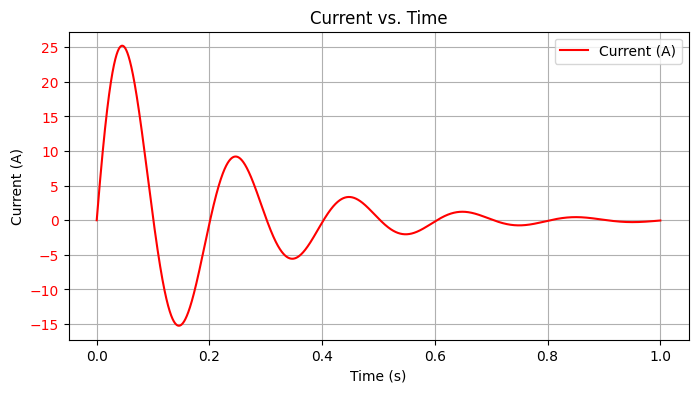

interactive(children=(FloatSlider(value=100.0, description='V0', max=450.0, step=1.0), FloatLogSlider(value=0.…

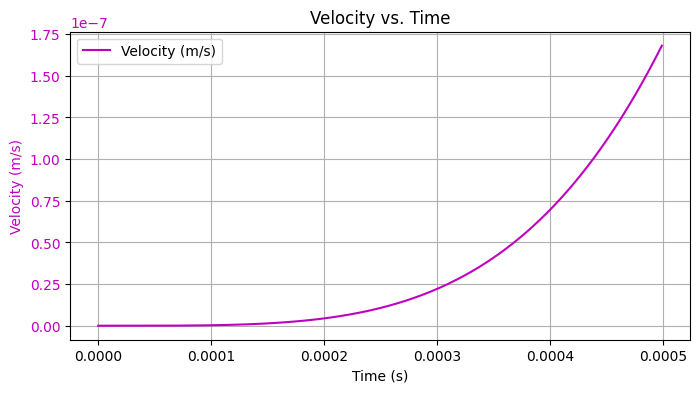

In [5]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, FloatLogSlider
from scipy.integrate import solve_ivp, cumulative_trapezoid
import numpy as np

# Define the differential equation for the RLC circuit
def sys_model(t, y, C, L, R_total) :
    # Destructure the state vector
    [voltage, current, acceleration] = y
    
    # Rate of hange in voltage
    dVdt = current / C
    
    # Rate of change in current 
    dIdt = -(R_total * current + voltage) / L  # THIS is secret sauce, courtesy of ChatGPT

    # Compute accelation on the projective using the magnetic forcde
    Phi = L * current  # Magnetic flux
    F = (Phi**2) / (2 * L)  # Force based on magnetic flux
    dvdt = F / proj_mass 
    
    return [ dVdt, dIdt, dvdt ]

def run_sim(init_volts, capacitance, inductance, resistance, duration_seconds):
    # Initial voltage across cap, current across inductor, init position of projective, init velocity of projectiile
    init_conditions = [-init_volts, 0, 0]
    t_span = (0, duration_seconds)  # Simulation time bounds
    t_eval = np.linspace(t_span[0], t_span[1], 1000000)      # Set simulation granularity

    # Solve the differential equation
    return solve_ivp(sys_model, t_span, init_conditions, t_eval=t_eval, args=(capacitance, inductance, resistance))

# Interactive sliders for the parameters
V0_slider = FloatSlider(value=100, min=0, max=450, step=1, description='V0')
C_slider = FloatLogSlider(value=0.01, base=10, min=-6, max=2, step=0.1, description='C')
L_slider = FloatSlider(value=0.1, min=0.001, max=1, step=0.001, description='L')
R_slider = FloatSlider(value=1, min=0.1, max=10, step=0.1, description='R')
duration_slider = FloatLogSlider(value=1, base=10, min=-3, max=2, step=0.1, description='Duration')

def solve_and_plot(V0, C, L, R, duration_seconds):
    global circuit_solution
    circuit_solution = run_sim(V0, C, L, R, duration_seconds)
    plot_circuit(circuit_solution)
    
interact(
    solve_and_plot,
    V0=V0_slider,
    C=C_slider,
    L=L_slider,
    R=R_slider,
    duration_seconds=duration_slider
)

# circuit_solution=run_sim(V0, C, L, R_total, 1)
# Geschwindigkeit
# Perform the cumulative integration
velocity = cumulative_trapezoid(circuit_solution.y[2], circuit_solution.t)
plot_velocity(circuit_solution.t[:500], velocity[0:500])

# print(circuit_solution)

In [19]:
# Calculate magnitude of magnetic field
# V, I = circuit_solution.y
# B = mu_0 * (N_turns / coil_length) * I
# B_max = max(B, key=abs)
# print(f"B_max: {B_max:.3} Tesla")

# Create a third y-axis for the magnetic field strength
# fig, ax3 = plt.subplots(figsize=(10, 5))
# ax3.plot(t, B, 'g-', label='Magnetic Field (T)')
# ax3.set_xlabel('Time (µs)')  # Set x-axis label to microseconds
# ax3.set_ylabel('Magnetic Field (T)', color='g')
# ax3.tick_params(axis='y', labelcolor='g')

# Plot the magnetic flux
# fig, ax4 = plt.subplots(figsize=(10, 5))
# ax4.plot(t, Phi, 'm-', label='Magnetic Flux (Wb)')
# ax4.set_xlabel('Time (µs)')  # Set x-axis label to microseconds
# ax4.set_ylabel('Magnetic Flux (Wb)', color='m')
# ax4.tick_params(axis='y', labelcolor='m')

In [20]:


# plot_solution(simulate_circuit(V0, C, L, R_total, 1))

# def plot_simulation(V0, C, L, R, duration_seconds) :
#     plot_solution(simulate_circuit(V0, C, L, R, duration_seconds))

# plot_simulation(V0, C, L, R_total, 1) 

# interact(plot_simulation, V0=V0, C=cap_slider, L=L, R=R_total, duration_seconds=1)
              